# Trimodal integration and query-to-reference mapping

In this notebook we demonstrate how to build a trimodal reference atlas and map unimodal as well as multimodal query data onto the reference. We use publically available dataset from NeurIPS 2021 workshop {cite:p}`Luecken2021-ct`. Please also refer to the tutorial on paired integration for more detailed explanation of the preprocessing steps and the model setup.

In [1]:
import sys

# if branch is stable, will install via pypi, else will install from source
branch = "latest"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install multigrate[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install muon
    !pip install --quiet --upgrade jsonschema
    !pip install git+https://github.com/theislab/multigrate

In [2]:
import anndata as ad
import json
import multigrate as mtg
import numpy as np
import scanpy as sc
import scvi
import warnings

warnings.filterwarnings("ignore")

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.4.0.post1


## Data loading

The original CITE-seq data (i.e. paired gene expression and surface protein adundance) contains 90,261 bone marrow mononuclear cells. This CITE-seq  dataset was generated at 4 different sites introducing some batch effect. After the quality control (QC) performed by the authors, the data contains measurements from 13,953 genes and 134 proteins. 

The multiome data (i.e. paired gene expression and chromatin openness) contains 69249 cells from the same donors as the CITE-seq dataset. It also was generated at the same 4 sites. After QC, the data has 13,431 genes and 116,490 peaks.

In this tutorial, we provide subsetted and preprocessed data. Both datasets were randomly subsampled to 20,000 cells each. We also selected 2,000 highly variable genes and 20,000 highly variable pe We use raw RNA counts, centered log-ratio (CLR) normalized data for ADT and log-normalized data for ATAC.

In [4]:
rna_cite_path = "rna_cite.h5ad"
rna_multiome_path = "rna_multiome.h5ad"
atac_path = "atac.h5ad"
adt_path = "adt.h5ad"

In [5]:
try:
    rna_cite = sc.read_h5ad(rna_cite_path)
except OSError:
    import gdown

    gdown.download("https://drive.google.com/uc?export=download&id=1Qzc51EtK0eF5Gi62ucChXHcUxU99Eg-D")
    rna_cite = sc.read_h5ad(rna_cite_path)

rna_cite

Downloading...
From: https://drive.google.com/uc?export=download&id=1Qzc51EtK0eF5Gi62ucChXHcUxU99Eg-D
To: /Users/anastasia.litinetskaya/Documents/code/multigrate/docs/notebooks/rna_cite.h5ad
100%|██████████| 40.9M/40.9M [00:03<00:00, 13.4MB/s]


AnnData object with n_obs × n_vars = 20000 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'log1p'

In [6]:
try:
    atac = sc.read_h5ad(atac_path)
except OSError:
    import gdown

    gdown.download("https://drive.google.com/uc?export=download&id=17RuUsgKZN41MMfDo6C_oEN4CYWJKnL8H")
    atac = sc.read_h5ad(atac_path)
atac

Downloading...
From (original): https://drive.google.com/uc?export=download&id=17RuUsgKZN41MMfDo6C_oEN4CYWJKnL8H
From (redirected): https://drive.google.com/uc?export=download&id=17RuUsgKZN41MMfDo6C_oEN4CYWJKnL8H&confirm=t&uuid=3125a99a-0df9-4b33-9bfc-d68b62eb6611
To: /Users/anastasia.litinetskaya/Documents/code/multigrate/docs/notebooks/atac.h5ad
100%|██████████| 107M/107M [00:07<00:00, 13.5MB/s] 


AnnData object with n_obs × n_vars = 20000 × 20000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'hvg', 'log1p', 'organism'

In [7]:
try:
    adt = sc.read_h5ad(adt_path)
except OSError:
    import gdown

    gdown.download("https://drive.google.com/uc?export=download&id=1mlpwwALGDpCCxZS2-laApOEdoYksPhFf")
    adt = sc.read_h5ad(adt_path)
adt

Downloading...
From: https://drive.google.com/uc?export=download&id=1mlpwwALGDpCCxZS2-laApOEdoYksPhFf
To: /Users/anastasia.litinetskaya/Documents/code/multigrate/docs/notebooks/adt.h5ad
100%|██████████| 20.9M/20.9M [00:01<00:00, 13.5MB/s]


AnnData object with n_obs × n_vars = 20000 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'

In [8]:
try:
    rna_multiome = sc.read_h5ad(rna_multiome_path)
except OSError:
    import gdown

    gdown.download("https://drive.google.com/uc?export=download&id=1W1oLSwB9IXL8OTVoxFopn2kqtOfdbXzE")
    rna_multiome = sc.read_h5ad(rna_multiome_path)

rna_multiome

Downloading...
From: https://drive.google.com/uc?export=download&id=1W1oLSwB9IXL8OTVoxFopn2kqtOfdbXzE
To: /Users/anastasia.litinetskaya/Documents/code/multigrate/docs/notebooks/rna_multiome.h5ad
100%|██████████| 32.9M/32.9M [00:03<00:00, 10.9MB/s]


AnnData object with n_obs × n_vars = 20000 × 2000
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'log1p'

### Cell type harmonization

Since the cell type annotation was performed separately for the CITE-seq and multiome datasets, we perform minimal label harmonization.

In [9]:
celltype_path = "cellttype_harmonize.json"

try:
    with open("cellttype_harmonize.json") as f:
        harmonized_celltypes = json.load(f)
except OSError:
    import gdown

    gdown.download("https://drive.google.com/uc?export=download&id=1dWT5PbGqf7I3GSjYLNXJRwdV6GJoQYL4")
    with open("cellttype_harmonize.json") as f:
        harmonized_celltypes = json.load(f)
harmonized_celltypes.keys()

dict_keys(['cite_ct_l1_map', 'cite_ct_l2_map', 'multi_ct_l1_map', 'multi_ct_l2_map'])

In [10]:
rna_cite.obs["l1_cell_type"] = rna_cite.obs["cell_type"].map(harmonized_celltypes["cite_ct_l1_map"])
rna_cite.obs["l2_cell_type"] = rna_cite.obs["cell_type"].map(harmonized_celltypes["cite_ct_l2_map"])

adt.obs["l1_cell_type"] = adt.obs["cell_type"].map(harmonized_celltypes["cite_ct_l1_map"])
adt.obs["l2_cell_type"] = adt.obs["cell_type"].map(harmonized_celltypes["cite_ct_l2_map"])

rna_multiome.obs["l1_cell_type"] = rna_multiome.obs["cell_type"].map(harmonized_celltypes["multi_ct_l1_map"])
rna_multiome.obs["l2_cell_type"] = rna_multiome.obs["cell_type"].map(harmonized_celltypes["multi_ct_l2_map"])

atac.obs["l1_cell_type"] = atac.obs["cell_type"].map(harmonized_celltypes["multi_ct_l1_map"])
atac.obs["l2_cell_type"] = atac.obs["cell_type"].map(harmonized_celltypes["multi_ct_l2_map"])

## Data setup

Next, we concatenate all the data into one AnnData object specifying how the data is paired and which layers to use. Each sublist in the `adatas` should correspond to one modality, and the order in each sublist indicates which objects are paired. In the example below, the first sublist corresponds to RNA, the second -- to ATAC, and the last -- to ADT. We pair `rna_cite` and `adt` objects by putting them at the first objects in the sublists, and `rna_multiome` and `atac` -- as socend. The missing measurements need to be filled with `None`.

Since we already have the raw counts in `.X` for rna objects, and normalized data for `adt` and `atac`, we don't need to specify the layers parameter.

In [11]:
rna_cite.X.data, rna_multiome.X.data

(array([ 2., 38.,  6., ...,  2.,  1.,  1.], dtype=float32),
 array([1., 2., 1., ..., 3., 1., 1.], dtype=float32))

In [12]:
adt.X.data, atac.X.data

(array([0.38965088, 0.669331  , 0.669331  , ..., 1.054183  , 0.2851298 ,
        1.4059474 ], dtype=float32),
 array([1.7362776, 1.7362776, 1.7362776, ..., 1.939339 , 1.939339 ,
        1.939339 ], dtype=float32))

In [13]:
adata = mtg.data.organize_multimodal_anndatas(
    adatas=[[rna_cite, rna_multiome], [None, atac], [adt, None]],
    layers=[[None, None], [None, None], [None, None]],
)
adata

AnnData object with n_obs × n_vars = 40000 × 22134
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type', 'group', 'ADT_iso_count', 'ADT_n_antibodies_by_counts', 'ADT_pseudotime_order', 'ADT_total_counts', 'GEX_n_genes_by_counts', 'is_train', 'ATAC_atac_fragments', 'ATAC_blacklist_fraction', 'ATAC_nCount_peaks', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'ATAC_reads_in_peaks_frac', 'GEX_n_counts', 'GEX_n_genes'
    var: 'modality'
    uns: 'modality_lengths'

The data comes from 4 different sites, so we select one of the sites as the query.

In [14]:
query = adata[adata.obs["Site"] == "site1"].copy()
adata = adata[adata.obs["Site"] != "site1"].copy()
(adata, query)

(AnnData object with n_obs × n_vars = 31521 × 22134
     obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type', 'group', 'ADT_iso_count', 'ADT_n_antibodies_by_counts', 'ADT_pseudotime_order', 'ADT_total_counts', 'GEX_n_genes_by_counts', 'is_train', 'ATAC_atac_fragments', 'ATAC_blacklist_fraction', 'ATAC_nCount_peaks', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'ATAC_reads_in_peaks_frac', 'GEX_n_counts', 'GEX_n_genes'
     var: 'modality'
     uns: 'modality_lengths',
 AnnData object with n_obs × n_vars = 8479 × 22134
     obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI',

Next, we register covariates that the model will correct for in the latent space. We need to pass the length of the RNA data to calculate the library size.

In [15]:
rna_indices_end = rna_cite.shape[1]

In [16]:
# to free memory
del rna_cite, rna_multiome, atac, adt

In [17]:
mtg.model.MultiVAE.setup_anndata(
    adata,
    categorical_covariate_keys=["Modality", "Samplename"],
    rna_indices_end=rna_indices_end,
)

## Model setup and training

We specify `integrate_on = 'Modality'` to make sure that joint distributions for CITE-seq and multiome data are well aligned. We also need to specify `alignment_type="marginal"` and `modality_alignment = 'MMD'` parameters to allow for unimodal reference mapping later. This ensures that the distributions of the CITE-seq and multiome data are aligned in the latent space as well as the unimodal marginal distributions. 

The integration coefficient (`'integ'`) in `loss_coefs` usually requires some fine-tuning and is dependent on the dataset.

If using raw counts for RNA-seq, specify NB loss, if normalized counts, use MSE loss. For ATAC and ADT, we use normalized counts and MSE loss.

In [18]:
vae = mtg.model.MultiVAE(
    adata,
    losses=["nb", "mse", "mse"],
    loss_coefs={
        "integ": 500,
    },
    integrate_on="Modality",
    alignment_type="marginal",
    modality_alignment="MMD",
)

The user can specify the number of epochs, learning rate and batch size by setting `max_epochs`, `lr` and `batch_size`, respectively. Please refer to the API for more details.

In [19]:
vae.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Monitored metric reconstruction_loss_validation did not improve in the last 10 records. Best score: 1038.537. Signaling Trainer to stop.


## Visualizing the latent space

Next, we retrieve the learned latent representation; it is automatically saved in `adata.obsm['X_multigrate']`.

In [20]:
vae.get_model_output()
adata

AnnData object with n_obs × n_vars = 31521 × 22134
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type', 'group', 'ADT_iso_count', 'ADT_n_antibodies_by_counts', 'ADT_pseudotime_order', 'ADT_total_counts', 'GEX_n_genes_by_counts', 'is_train', 'ATAC_atac_fragments', 'ATAC_blacklist_fraction', 'ATAC_nCount_peaks', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'ATAC_reads_in_peaks_frac', 'GEX_n_counts', 'GEX_n_genes', 'size_factors', '_scvi_batch'
    var: 'modality'
    uns: 'modality_lengths', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs', 'X_multigrate'

Finally, we visualize the latent space.

In [21]:
sc.pp.neighbors(adata, use_rep="X_multigrate")
sc.tl.umap(adata)

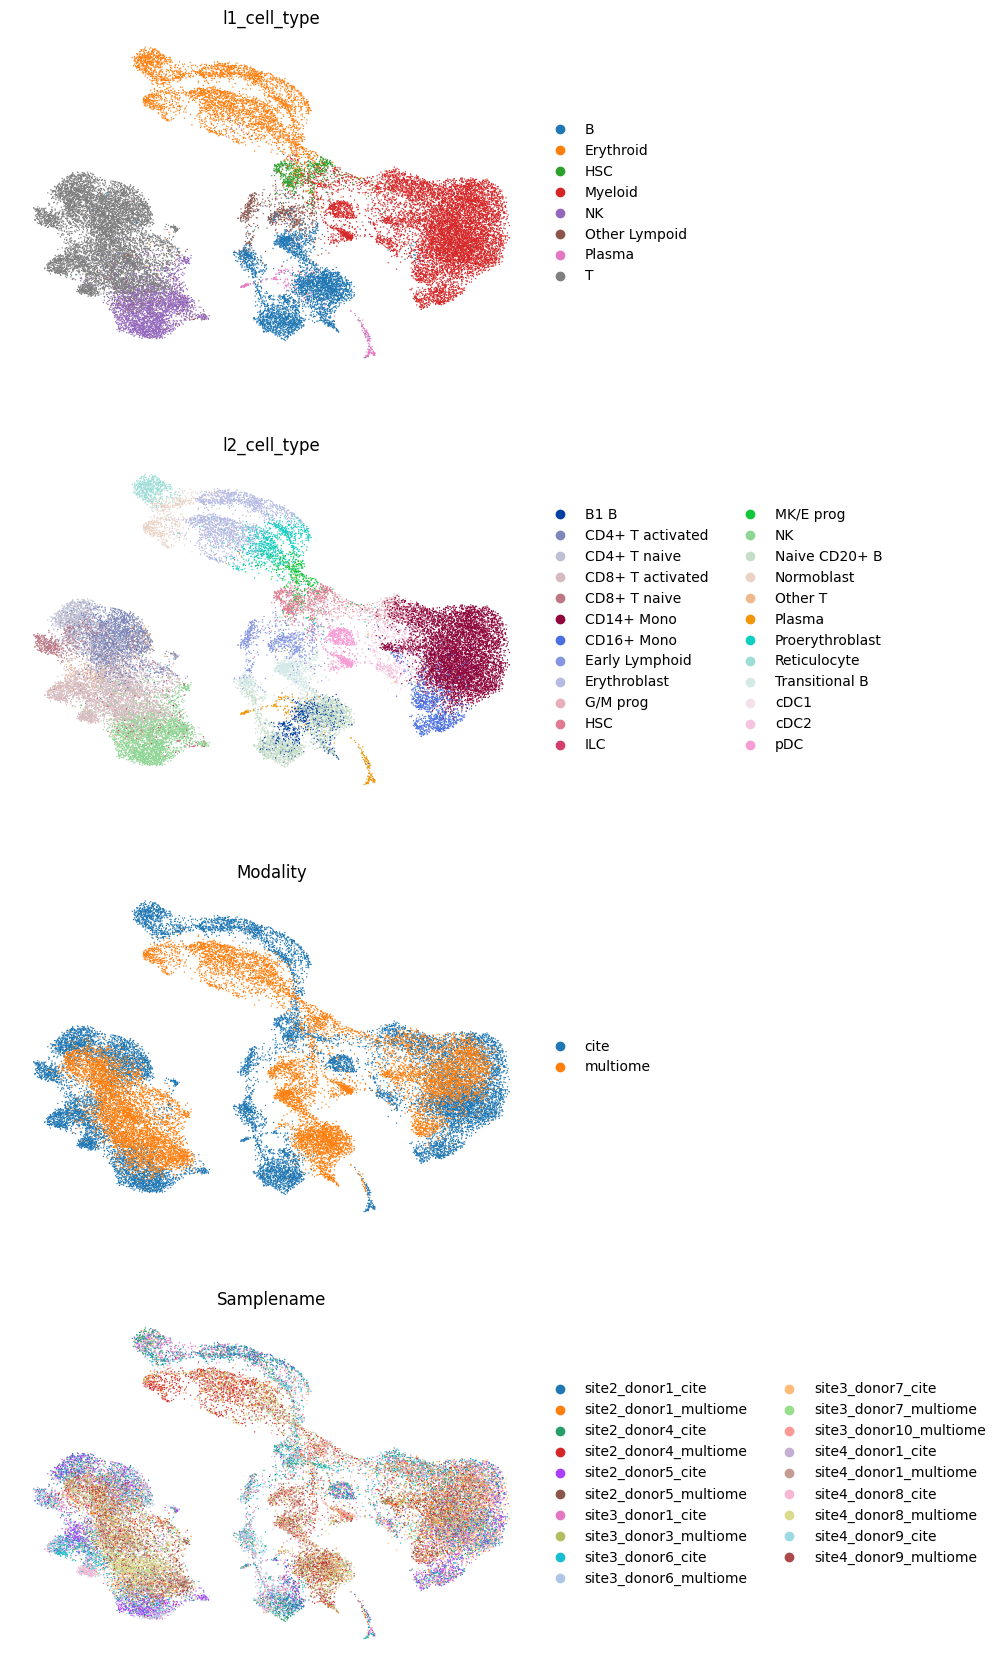

In [22]:
sc.pl.umap(adata, color=["l1_cell_type", "l2_cell_type", "Modality", "Samplename"], ncols=1, frameon=False)

## Preparing the query

Multigrate is equipped with scArches approach {cite:p}`Lotfollahi2022-jw` to map new query data onto existing references. Since we have three modalities in the reference, we can map multimodal and unimodal queries (even when we did not have any unimodal data in the reference). 

Let's imitate unimodal queries by masking with zeros the RNA part of one multiome sample and the ADT part of one CITE-seq samples in the query. We get one ATAC-only query sample and one RNA-only query sample respectively.

In [23]:
np.unique(query.obs["Samplename"])

array(['site1_donor1_cite', 'site1_donor1_multiome', 'site1_donor2_cite',
       'site1_donor2_multiome', 'site1_donor3_cite',
       'site1_donor3_multiome'], dtype=object)

In [24]:
idx_atac_query = query.obs["Samplename"] == "site1_donor1_multiome"
idx_scrna_query = query.obs["Samplename"] == "site1_donor1_cite"

idx_mutiome_query = query.obs["Samplename"].isin(["site1_donor2_multiome", "site1_donor3_multiome"])
idx_cite_query = query.obs["Samplename"].isin(["site1_donor2_cite", "site1_donor3_cite"])

np.sum(idx_atac_query), np.sum(idx_scrna_query), np.sum(idx_mutiome_query), np.sum(idx_cite_query)

(1751, 1140, 3161, 2427)

In [25]:
query[idx_atac_query, :rna_indices_end].X = 0
query[idx_scrna_query, rna_indices_end:].X = 0

Next, we initialize a new model taking the weights from the reference model but add new weights for the query batches, i.e. samples, following the scArches approach {cite:p}`Lotfollahi2022-jw`.

In [26]:
new_vae = mtg.model.MultiVAE.load_query_data(query, vae)

Next, we fine-tune the newly added weights to optimize the reconstruction of the query data. We set `weight_decay` to zero to make sure that the rest of the weights in the model will not be changed.

In [27]:
new_vae.train(weight_decay=0)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


Training:   0%|          | 0/200 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Now, we obtain the latent representation of the query and visualize both the reference and the query together.

In [28]:
new_vae.get_model_output(query)
query

AnnData object with n_obs × n_vars = 8479 × 22134
    obs: 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'l1_cell_type', 'l2_cell_type', 'group', 'ADT_iso_count', 'ADT_n_antibodies_by_counts', 'ADT_pseudotime_order', 'ADT_total_counts', 'GEX_n_genes_by_counts', 'is_train', 'ATAC_atac_fragments', 'ATAC_blacklist_fraction', 'ATAC_nCount_peaks', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'ATAC_reads_in_peaks_frac', 'GEX_n_counts', 'GEX_n_genes', 'size_factors', '_scvi_batch'
    var: 'modality'
    uns: 'modality_lengths', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs', 'X_multigrate'

In [29]:
adata.obs["reference"] = "reference"
query.obs["reference"] = "query"

adata.obs["type_of_query"] = "reference"
query.obs.loc[idx_atac_query, "type_of_query"] = "ATAC query"
query.obs.loc[idx_scrna_query, "type_of_query"] = "scRNA query"
query.obs.loc[idx_mutiome_query, "type_of_query"] = "multiome query"
query.obs.loc[idx_cite_query, "type_of_query"] = "CITE-seq query"

In [30]:
adata_both = ad.concat([adata, query])

In [31]:
sc.pp.neighbors(adata_both, use_rep="X_multigrate")
sc.tl.umap(adata_both)

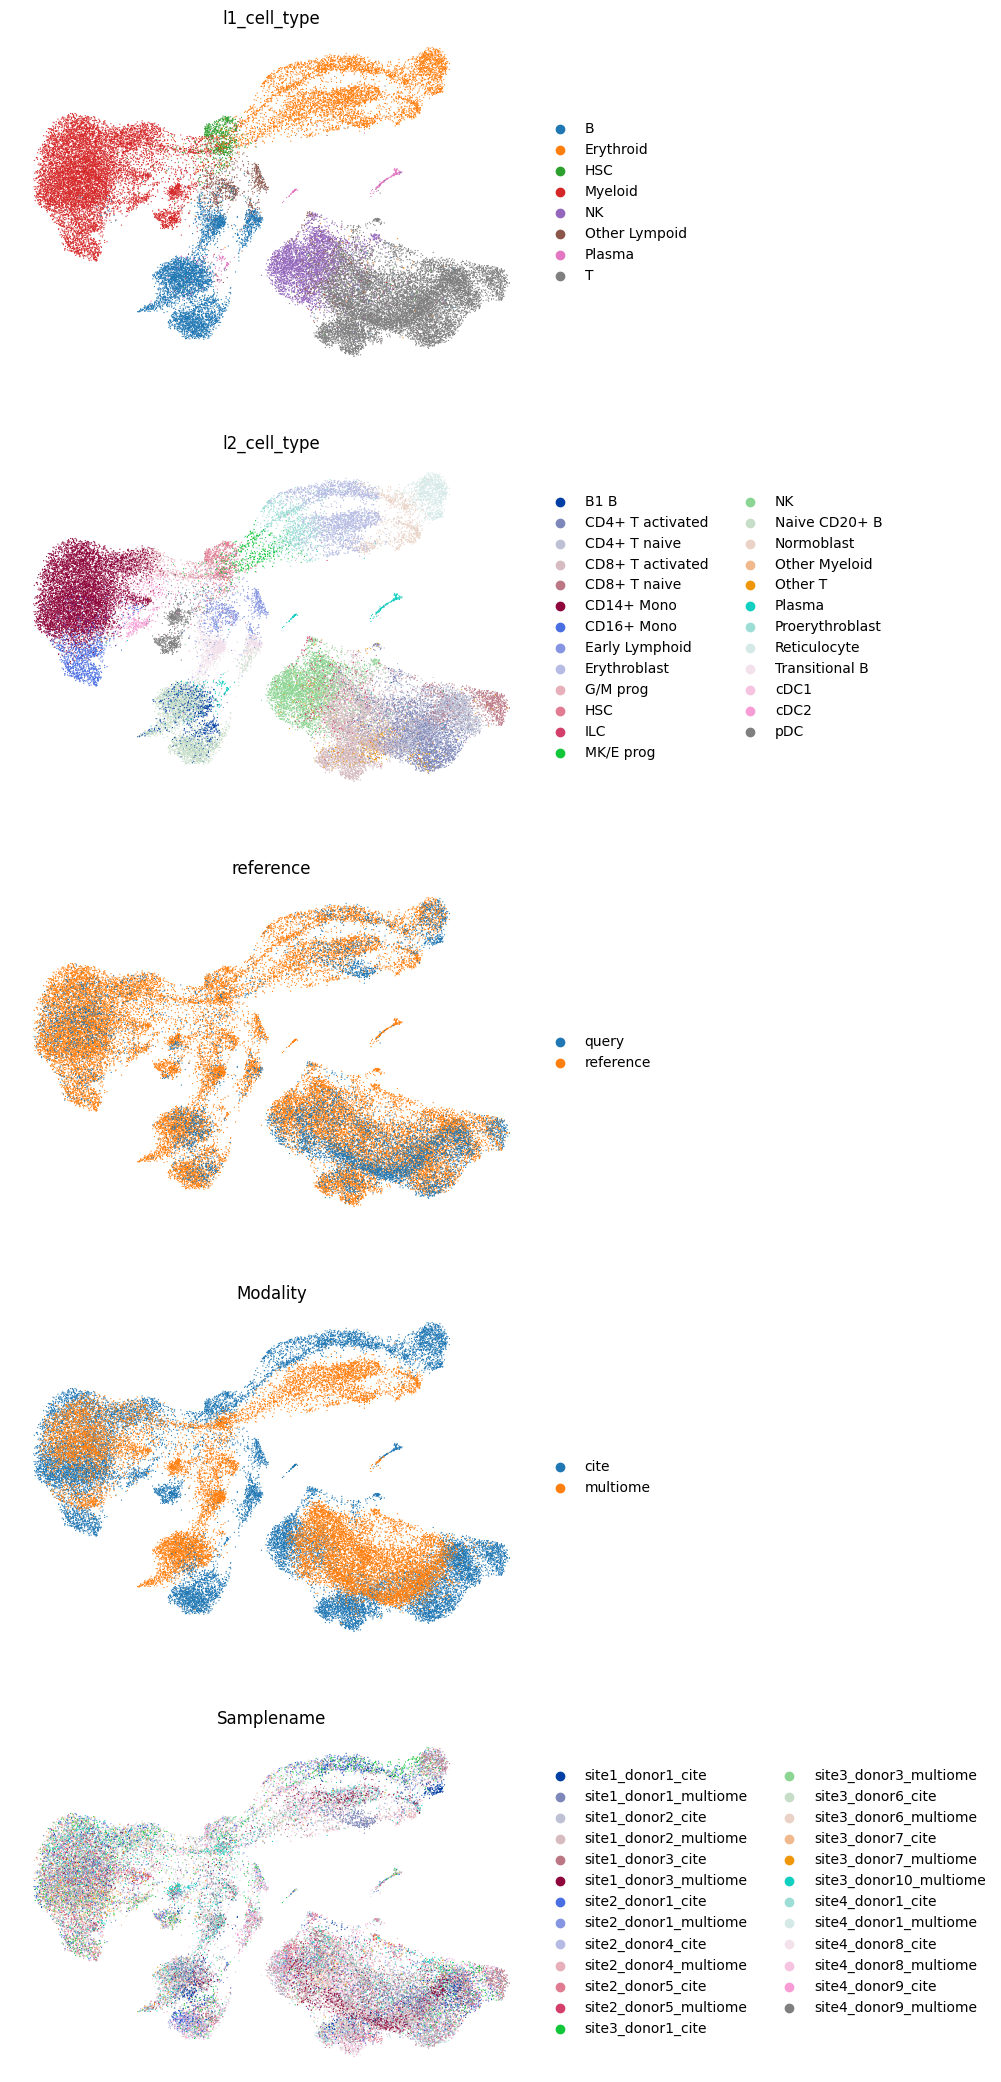

In [32]:
sc.pl.umap(
    adata_both, color=["l1_cell_type", "l2_cell_type", "reference", "Modality", "Samplename"], ncols=1, frameon=False
)

We also can take a look at separate multimodal and unimodal queries.

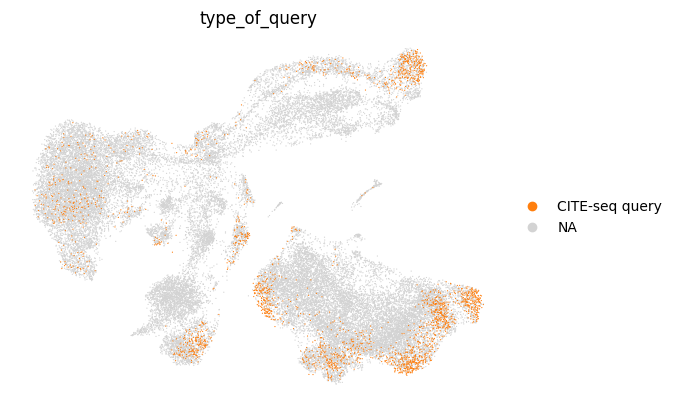

In [33]:
sc.pl.umap(adata_both, color="type_of_query", ncols=1, frameon=False, groups=["CITE-seq query"])

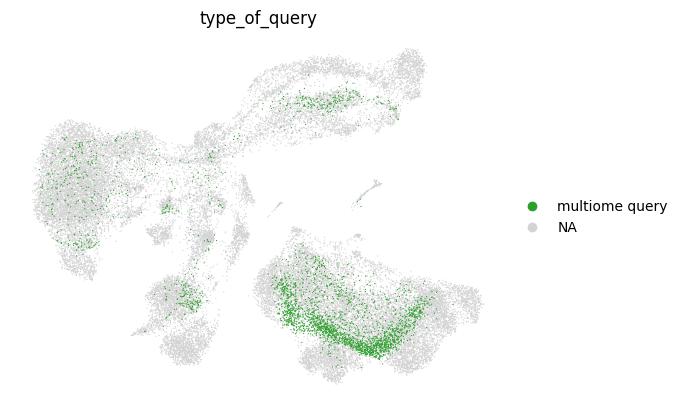

In [34]:
sc.pl.umap(adata_both, color="type_of_query", ncols=1, frameon=False, groups=["multiome query"])

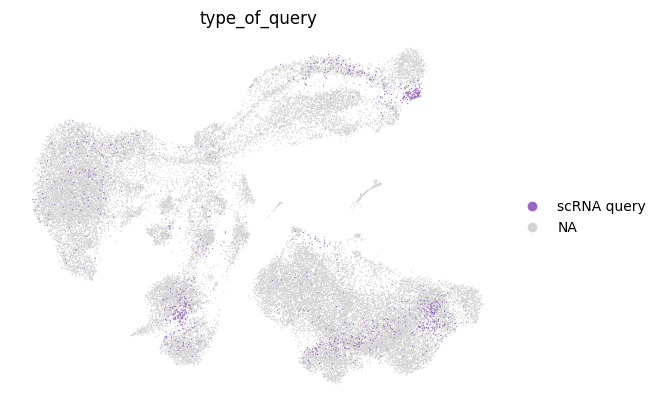

In [35]:
sc.pl.umap(adata_both, color="type_of_query", ncols=1, frameon=False, groups=["scRNA query"])

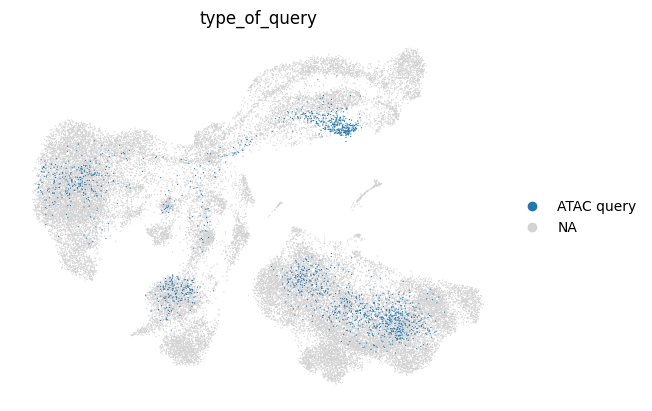

In [36]:
sc.pl.umap(adata_both, color="type_of_query", ncols=1, frameon=False, groups=["ATAC query"])